## Load_data


In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
data = np.load(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/dataset/ds.npy")
gt = np.load(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/dataset/gt.npy")
print(data.shape)
print(gt.shape)

(145, 145, 200)
(145, 145)


In [3]:
H = data.shape[0]
W = data.shape[1]
#归一化
scaler = StandardScaler()
voxel = scaler.fit_transform(data.reshape(-1, data.shape[-1]))
print(voxel.shape)
#PCA 
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(voxel)
print(principalComponents.shape)
# principalDF = pd.DataFrame(data=principalComponents, columns=["pc%d"%x for x in range(30)])
# print(principalDF)
fullDataX = principalComponents.reshape(H,W,30)
fullDataY = gt
print("fullDataX:",fullDataX.shape)
print("fullDataY:",gt.shape)

(21025, 200)
(21025, 30)
fullDataX: (145, 145, 30)
fullDataY: (145, 145)


In [4]:
import cv2
from skimage.util import view_as_windows
np.random.seed(666)
print(fullDataX.shape)
#(145,145,30) -> (176,176,30)
paddedDatax = cv2.copyMakeBorder(fullDataX, 16, 15, 16, 15, cv2.BORDER_CONSTANT, value=0)
print(paddedDatax.shape)
#(176,176,30) -> (145,145,1,32,32,30) 176-32+1=145 || 3-3+1=1
X_train = view_as_windows(paddedDatax, (32, 32, 30), step=1).reshape(-1,32,32,30)
#(145,145,1,32,32,30) -> (21025,32,32,03)
y_train = fullDataY.reshape(-1,)
p = np.random.permutation(len(X_train))
X_train=X_train[p]
y_train=y_train[p]
print(X_train.shape)
print(y_train.shape)

(145, 145, 30)
(176, 176, 30)
(21025, 32, 32, 30)
(21025,)


In [5]:
X_train = X_train[y_train>0,:,:,:]
y_train = y_train[y_train>0]
y_train = y_train - 1 #1-17 -> 0-16
print(X_train.shape)
print(y_train.shape)
data = X_train
label = y_train

(10249, 32, 32, 30)
(10249,)


In [6]:
GAN_data = np.load(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/EI_PAPER/New_data_generated_by_GAN/generated_data.npy")
GAN_label = np.load(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/EI_PAPER/New_data_generated_by_GAN/generated_label.npy")
GAN_label = GAN_label - 1
print(GAN_data.shape)
print(GAN_label.shape)

(10249, 32, 32, 30)
(10249,)


In [7]:
all_data = np.concatenate((X_train, GAN_data))
all_label = np.concatenate((y_train, GAN_label))
print(all_data.shape)
print(all_label.shape)

(20498, 32, 32, 30)
(20498,)


In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

tf.random.set_seed(666)
batch_sz=32
X, test_data, Y, test_label = train_test_split(all_data, all_label, test_size=0.3, random_state=666)
train_data, valid_data, train_label, valid_label = train_test_split(X, Y, test_size=0.2, random_state=666)

print(train_data.shape, train_label.shape)
print(valid_data.shape, valid_label.shape)
print(test_data.shape, test_label.shape)


(11478, 32, 32, 30) (11478,)
(2870, 32, 32, 30) (2870,)
(6150, 32, 32, 30) (6150,)


## Model_define

In [0]:
from tensorflow.keras.layers import Dense, Conv3D, Conv2D, Flatten, Reshape, Dropout, Input, Activation, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf
channel = 30
#input_layer (None,32,32,30)
input_layer = Input(shape=(32,32,30))
#Conv_layer
Conv1 = Conv2D(filters=60, kernel_size=(3,3),activation="relu")(input_layer)
Conv2 = Conv2D(filters=90, kernel_size=(3,3),activation="relu")(Conv1)

#fully_Connected_layer
flatten_layer = Flatten()(Conv1)
Dense1 = Dense(units=160, activation="relu")(flatten_layer)
Dense1 = Dropout(0.25)(Dense1)
output_layer = Dense(units=16, activation="softmax")(Dense1)

Conv2D_net = Model(input_layer, output_layer)

In [10]:
Conv2D_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 30)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 60)        16260     
_________________________________________________________________
flatten (Flatten)            (None, 54000)             0         
_________________________________________________________________
dense (Dense)                (None, 160)               8640160   
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2576      
Total params: 8,658,996
Trainable params: 8,658,996
Non-trainable params: 0
___________________________________________________

In [0]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os 
path = r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/EI_PAPER/weights_and_models"
save = os.path.join(path,"best_Conv2D_net.h5")

adam = optimizers.Adam(learning_rate=0.0005, decay=1e-6)
checkpoint = ModelCheckpoint(save, monitor='acc', verbose=0, save_best_only=True, mode='max')
earlystopping = EarlyStopping(patience=10, min_delta=1e-4)
callbacks_list = [checkpoint,earlystopping]
Conv2D_net.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
Conv2D_net.load_weights(save)

In [13]:

os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
history = Conv2D_net.fit(train_data, train_label,
              epochs=100,
              batch_size=batch_sz,
              validation_data=(valid_data, valid_label),
              callbacks=callbacks_list)


Epoch 1/100
359/359 [==============================] - 2s 7ms/step - loss: 0.2719 - accuracy: 0.9204 - val_loss: 0.0358 - val_accuracy: 0.9920
Epoch 2/100
359/359 [==============================] - 4s 11ms/step - loss: 0.1404 - accuracy: 0.9604 - val_loss: 0.0113 - val_accuracy: 0.9962
Epoch 3/100
359/359 [==============================] - 3s 9ms/step - loss: 0.0763 - accuracy: 0.9767 - val_loss: 0.0214 - val_accuracy: 0.9948
Epoch 4/100
359/359 [==============================] - 3s 9ms/step - loss: 0.0688 - accuracy: 0.9780 - val_loss: 0.0291 - val_accuracy: 0.9944
Epoch 5/100
359/359 [==============================] - 3s 7ms/step - loss: 0.1011 - accuracy: 0.9739 - val_loss: 0.0379 - val_accuracy: 0.9944
Epoch 6/100
359/359 [==============================] - 2s 6ms/step - loss: 0.0833 - accuracy: 0.9767 - val_loss: 0.0177 - val_accuracy: 0.9965
Epoch 7/100
359/359 [==============================] - 2s 6ms/step - loss: 0.0558 - accuracy: 0.9836 - val_loss: 0.0050 - val_accuracy: 0.998

KeyboardInterrupt: ignored

In [0]:
path = r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/EI_PAPER/weights_and_models"
save = os.path.join(path,"best_Conv2D_net+GAN_data.h5")
Conv2D_net.save_weights(save)

In [15]:
Conv2D_net.evaluate(test_data, test_label, verbose=0)

[0.004460055846720934, 0.9983739852905273]

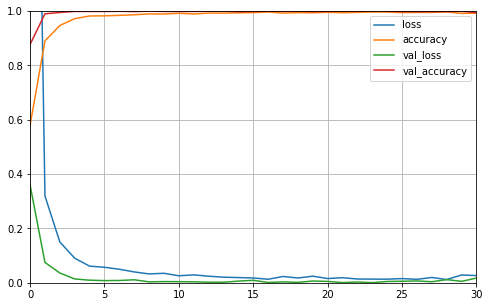

In [0]:
import matplotlib.pyplot as plt

def plot_learning_curves(history,epoch,min_val,max_val):
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.axis([0, epoch, min_val, max_val])
        plt.show()
plot_learning_curves(history,30,0,1)

In [0]:
width = 145
height = 145
PATCH_SIZE = 32
numComponents = 30
def Patch(data,height_index,width_index): #0-144 -> 32-176
  height_slice = slice(height_index, height_index+PATCH_SIZE)
  width_slice = slice(width_index, width_index+PATCH_SIZE)
  patch = data[height_slice, width_slice, :] 
  return patch

In [17]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = fullDataY[int(i), int(j)]
        if target == 0 :
            continue
        else :
            image_patch=Patch(paddedDatax,i,j)
            #print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1],image_patch.shape[2]).astype('float32')                                   
            prediction = (Conv2D_net.predict(X_test_image))   
            prediction = tf.argmax(prediction, axis=-1).numpy()                     
            outputs[int(i)][int(j)] = prediction+1
print(outputs.shape)

(145, 145)


In [18]:
!pip install spectral

     |████████████████████████████████| 194kB 4.9MB/s 


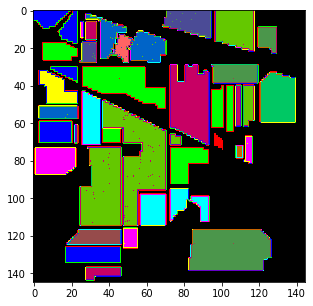

In [19]:
import spectral
# Plot the Ground Truth Image
ground_truth = spectral.imshow(classes = fullDataY,figsize =(5,5))

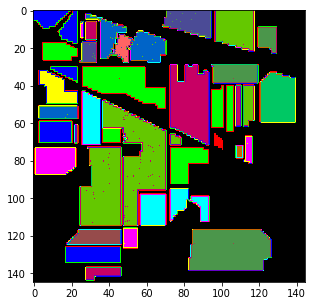

In [20]:
# Plot the Predicted image
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5))

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
def report(X_test, y_test, model):
  target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
              ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
              'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
              'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
              'Stone-Steel-Towers']
  y_pred = np.argmax(model.predict(X_test),axis=1)
  classification = classification_report(y_test, y_pred, target_names=target_names)
  confusion = confusion_matrix(y_test, y_pred)
  score = model.evaluate(X_test, y_test, batch_size=32)
  loss, accuracy = score[0], score[1]
  return classification, confusion, loss, accuracy
print(X_train.shape)
print(y_train.shape)
X_train = X_train.reshape(-1,32,32,30,1)
Conv2D_net.load_weights(r"/content/drive/My Drive/Marko/Model_learning/GAN/HSI-Classification-GAN/EI_PAPER/weights_and_models/best_Conv2D_net.h5")
classification, confusion, loss, accuracy = report(X_train, y_train, Conv2D_net)

(10249, 32, 32, 30)
(10249,)
321/321 [==============================] - 1s 4ms/step - loss: 7.7791e-04 - accuracy: 0.9997


In [22]:
print("{}".format(classification))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       1.00      1.00      1.00      1428
                Corn-mintill       1.00      1.00      1.00       830
                        Corn       1.00      1.00      1.00       237
               Grass-pasture       1.00      1.00      1.00       483
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      1.00      1.00       972
             Soybean-mintill       1.00      1.00      1.00      2455
               Soybean-clean       1.00      1.00      1.00       593
                       Wheat       1.00      1.00      1.00       205
                   